# Exercise 18.2 - Solution
## Generation of air-shower footprints using WGAN
In this tutorial we will learn how to implement Wasserstein GANs (WGAN) using tensorflow.keras.

Recall the description of a cosmic-ray observatory in Example 11.2 and Fig. 11.2b.
In response to a cosmic-ray-induced air shower, a small part of the detector stations is traversed by shower particles leading to characteristic arrival patterns (dubbed footprints, see Fig. 18.13).
The number of triggered stations increases with the cosmic-ray energy.
The signal response is largest close to the center of the shower.

#### Tasks
 1. Build a generator and a critic network which allows for the generation of $9 \times 9$ air-shower footprints.
 2. Set up the training by implementing the Wasserstein loss using the Kantorovich-Rubinstein duality.  
 3. Implement the main loop and train the framework for 15 epochs. Check the plots of the critic loss and generated air shower footprints.
 4. Name four general challenges of training adversarial frameworks.
 5. Explain why approximating the Wasserstein distance in the discriminator/critic helps to reduce mode collapsing.



This approach is a simplified version of: https://link.springer.com/article/10.1007/s41781-018-0008-x

Training WGAN can be computationally demanding, thus, we recommend to use a GPU for this task.

### Software
First we have to import our software. Used versions:

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
layers = keras.layers

print("tensorflow version", tf.__version__)
print("keras version", keras.__version__)

tensorflow version 2.5.0
keras version 2.5.0
numpy version 1.19.5


## Data
To train our generative model we need some data. In this case we want to generate cosmic-ray induced air showers. The showers were simulated using https://doi.org/10.1016/j.astropartphys.2017.10.006

In [2]:
import gdown

url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz"
output = 'airshowers.npz'
gdown.download(url, output, quiet=True)

'airshowers.npz'

In [3]:
file = np.load(output)
shower_maps = file['shower_maps']
nsamples = len(shower_maps)

Now, we can have a look at some random footprints of the data set.

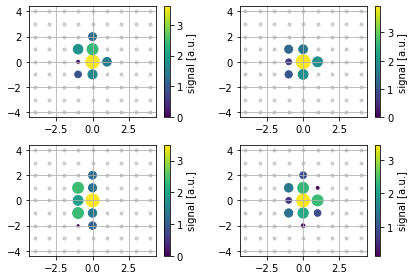

In [4]:
def rectangular_array(n=9):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)


for i,j in enumerate(np.random.choice(nsamples, 4)):
    plt.subplot(2,2,i+1)
    footprint=shower_maps[j,...,0]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                           s=marker_size, alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('signal [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Wasserstein GANs
To overcome the meaningless loss and vanishing gradients, [Arjovsky, Chintala and Bottou](https://arxiv.org/abs/1701.07875) proposed to use Wasserstein-1 as a metric in the discriminator.

Using the Wasserstein distance as a metric has several advantages in comparison to the old min-max loss. The crucial feature of the Wasserstein distance is a meaningful distance measure even when distributions are disjunct. But before coming to the essential difference, let us try to understand the Wasserstein distance.

### Generator
For training GANs we need to further define our generator and discriminator network. We start by defining our generator network, which should map from our noise + label space into the space of images (latent-vector size --> image size). Adding the label the input of to both the generator and discriminator should enforce the generator to produce samples from the according class.

#### Task
Design a meaningful generator model! Remember to check the latent and image dimensions. You can make use of the 'DCGAN guidelines' (See Sec. 18.2.3).
Use a meaningful last activation function!

In [5]:
def generator_model(latent_size):
    """ Generator network """
    latent = layers.Input(shape=(latent_size,), name="noise")
    z = layers.Dense(latent_size)(latent)
    z = layers.Reshape((1, 1, latent_size))(z)
    z = layers.UpSampling2D(size=(3, 3))(z)
    z = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(z)
    z = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(z)
    z = layers.UpSampling2D(size=(3, 3))(z)
    z = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(z)
    z = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(z)
    z = layers.Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(z)
    z = layers.Activation("relu")(z)
    return keras.models.Model(latent, z, name="generator")

Now we can build and check the shapes of our generator.

In [6]:
latent_size = 128
g = generator_model(latent_size)
g.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 256)         295168    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 256)         590080    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 9, 9, 256)         0 

### Critic / Discriminator
The task of the discriminator is to measure the similarity between the fake images (output of the generator) and the real images. So, the network maps from the image space into a 1D space where we can measure the 'distance' between the distributions of the real and generated images (image size --> scalar). Also, here we add the class label to the discriminator.

#### Task
Design a power- and meaningful critic model! Remember that you can make use of the DCGAN guidelines and check the image dimensions.
Do we need a "special" last activation function in the critic?

In [7]:
def critic_model():
    image = layers.Input(shape=(9,9,1), name="images")
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(9, 9, 1))(image)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', strides = (2,2), kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', strides = (2,2), kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(1)(x)  # no activation!
    return keras.models.Model(image, x, name="critic")


Let us now build and inspect the critic.

In [8]:
critic = critic_model()
critic.summary()

Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 9, 9, 1)]         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 5, 5, 128)         0    

## Training piplines
Below we have to design the pipelines for training the adversarial framework. 

In [9]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:
        # print(type(layer))
        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

Note that after we compiled a model, calling `make_trainable` will have no effect until we compile the model again.

Freeze the critic during the generator training and unfreeze the generator during the generator training

In [10]:
make_trainable(critic, False) 
make_trainable(g, True) # This is in principal not needed here

Now, we stack the generator on top of the critic and finalize the generator-training step.

In [11]:
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, critic(g(gen_input)))
generator_training.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 128)]             0         
_________________________________________________________________
generator (Functional)       (None, 9, 9, 1)           1345537   
_________________________________________________________________
critic (Functional)          (None, 1)                 1402497   
Total params: 2,748,034
Trainable params: 1,345,537
Non-trainable params: 1,402,497
_________________________________________________________________


We can further visualize this simple "computational graph".

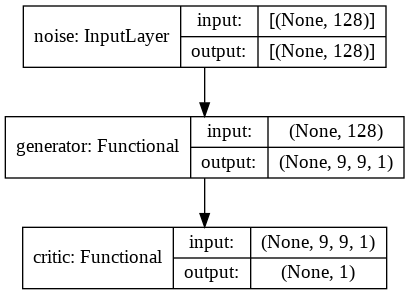

In [12]:
keras.utils.plot_model(generator_training, show_shapes=True)

#### Task
 - Implement the wasserstein_loss  
  
  

*Our output will be a half batch of fake and a half batch of real samples.  
Hence, one can design the Wasserstein loss as a multiplication between the fake and real samples (set noise = -1 and real = +1).  
Multiplying the outputs by the labels results in the wasserstein loss as given by the Kantorovich-Rubinstein duality (but the Lipschitz constraint is yet missing).*

In [13]:
import tensorflow.keras.backend as K

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

generator_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss])

### Gradient penalty
To obtain the final Wasserstein distance, we have to use the gradient penalty to enforce the Lipschitz constraint.

Therefore, we need to design a layer that samples on straight lines between reals and fakes samples 

In [14]:
BATCH_SIZE = 128

class UniformLineSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        weights = K.random_uniform((self.batch_size, 1, 1, 1))
        return(weights * inputs[0]) + ((1 - weights) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

We design the pipeline of the critic training by inserting generated (use generator + noise directly to circumvent expensive prediction step) and real samples into the sampling layer and additionally feeding generated and real samples into the critic.

In [15]:
make_trainable(critic, True)  # unfreeze the critic during the critic training
make_trainable(g, False)  # freeze the generator during the critic training

g_out = g(g.inputs)
critic_out_fake_samples = critic(g_out)
critic_out_data_samples = critic(critic.inputs)
averaged_batch = UniformLineSampler(BATCH_SIZE)([g_out, critic.inputs[0]])
averaged_batch_out = critic(averaged_batch)

critic_training = keras.models.Model(inputs=[g.inputs, critic.inputs], outputs=[critic_out_fake_samples, critic_out_data_samples, averaged_batch_out])

Let us visualize this "computational graph". The critic outputs will be used for the Wasserstein loss and the `UniformLineSampler` output for the gradient penalty.

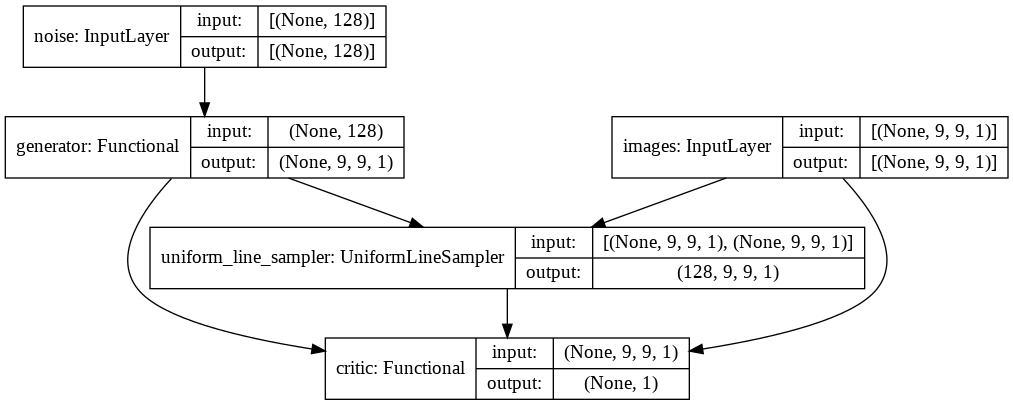

In [16]:
keras.utils.plot_model(critic_training, show_shapes=True)

In [17]:
critic_training.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              [(None, 128)]        0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 9, 9, 1)      1345537     noise[0][0]                      
__________________________________________________________________________________________________
images (InputLayer)             [(None, 9, 9, 1)]    0                                            
__________________________________________________________________________________________________
uniform_line_sampler (UniformLi (128, 9, 9, 1)       0           generator[1][0]                  
                                                                 images[0][0]               

We now design the gradient penalty as proposed by in https://arxiv.org/abs/1704.00028

In [18]:
from functools import partial

def gradient_penalty_loss(y_true, y_pred, averaged_batch, penalty_weight):
    """Calculates the gradient penalty.
    The 1-Lipschitz constraint of improved WGANs is enforced by adding a term that penalizes a gradient norm in the critic unequal to 1."""
    gradients = K.gradients(y_pred, averaged_batch)
    gradients_sqr_sum = K.sum(K.square(gradients)[0], axis=(1, 2, 3))
    gradient_penalty = penalty_weight * K.square(1 - K.sqrt(gradients_sqr_sum))
    return K.mean(gradient_penalty)


gradient_penalty = partial(gradient_penalty_loss, averaged_batch=averaged_batch, penalty_weight=10)  # construct the gradient penalty
gradient_penalty.__name__ = 'gradient_penalty'

Let us compile the critic. The losses have to be given in the order as we designed the model outputs (gradient penalty connected to the output of the sampling layer).

In [19]:
critic_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss, wasserstein_loss, gradient_penalty])

The labels for the training are (Remember we used as for the Wasserstein loss a simple multiplication to add a sign.)

In [20]:
positive_y = np.ones(BATCH_SIZE)
negative_y = -positive_y
dummy = np.zeros(BATCH_SIZE)  # keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss

### Training
We can now start the training loop.
In the WGAN setup, the critic is trained several times before the generator is updated.

#### Task
 - Implement the main loop.
 - Choose a reasonable number of `EPOCHS` until you see a cood convergence.
 - Choose a meaningful number of `critic_iterations`.

In [21]:
EPOCHS = 10
critic_iterations = 5

generator_loss = []
critic_loss = []

iterations_per_epoch = nsamples // (critic_iterations * BATCH_SIZE)
iters = 0

for epoch in range(EPOCHS):
    print("epoch: ", epoch)  
    
    for iteration in range(iterations_per_epoch):

        for j in range(critic_iterations):

            noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
            shower_batch = shower_maps[BATCH_SIZE*(j+iteration):BATCH_SIZE*(j++iteration+1)]  # take batch of shower maps
            critic_loss.append(critic_training.train_on_batch([noise_batch, shower_batch], [negative_y, positive_y, dummy]))  # train the critic

        noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
        generator_loss.append(generator_training.train_on_batch([noise_batch], [positive_y]))  # train the generator
        iters+=1
        
        generated_maps = g.predict_on_batch(np.random.randn(BATCH_SIZE, latent_size))
        
        if iters % 300 == 1:
            print("iteration", iters)
            print("critic loss:", critic_loss[-1])
            print("generator loss:", generator_loss[-1])

            for i in range(4):
                plt.subplot(2,2,i+1)
                footprint=generated_maps[i,...,0]
                xd, yd = rectangular_array()
                mask = footprint != 0
                mask[5, 5] = True
                marker_size = 50 * footprint[mask]
                plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
                circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                                       s=marker_size, alpha=1, label="loud")
                cbar = plt.colorbar(circles)
                cbar.set_label('signal [a.u.]')
                plt.grid(True)

            plt.suptitle("iteration %i" % iters)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig("./fake_showers_iteration_%.6i.png" % iters)
            plt.close("all")

epoch:  0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


iteration 1
critic loss: [-4.978128, -0.3126181, -5.8564796, 1.1909701]
generator loss: 0.48288947
epoch:  1
iteration 301
critic loss: [-0.27215886, -2.7607713, 2.403032, 0.08558045]
generator loss: 1.8206785
epoch:  2
epoch:  3
iteration 601
critic loss: [-0.35604954, -1.8754516, 1.4219406, 0.09746142]
generator loss: 1.9588864
epoch:  4
epoch:  5
iteration 901
critic loss: [-0.08997214, -0.6038897, 0.45670748, 0.05721009]
generator loss: 0.8612764
epoch:  6
epoch:  7
iteration 1201
critic loss: [-0.16930246, 3.0787382, -3.3308544, 0.08281368]
generator loss: -2.3519459
epoch:  8
epoch:  9
iteration 1501
critic loss: [0.100387335, 3.4348488, -3.395045, 0.060583502]
generator loss: -3.1515403


### Results
Let us plot the critic loss.
We now expect to see a convergence of the total loss if the training was successful.

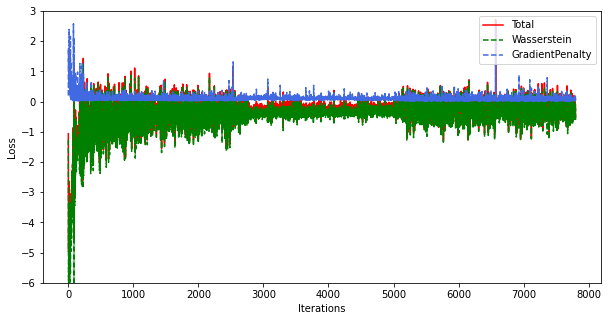

In [22]:
critic_loss = np.array(critic_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 0], color='red', markersize=12, label=r'Total')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 1] + critic_loss[:, 2], color='green', label=r'Wasserstein', linestyle='dashed')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 3], color='royalblue', markersize=12, label=r'GradientPenalty', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.ylim(-6, 3)
plt.show()

In addition, we can visualize the generator loss.

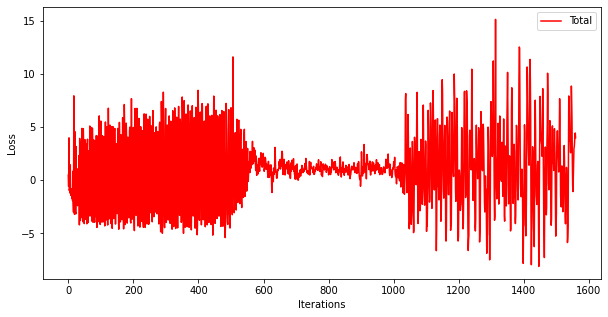

In [23]:
generator_loss = np.array(generator_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(generator_loss)), generator_loss, color='red', markersize=12, label=r'Total')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.show()

#### Plot generated footprints
To nicely see the training progress, we can create a gif of the generated samples during the training.

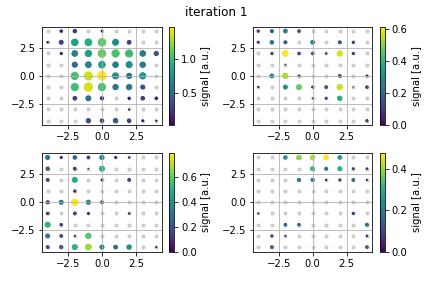

In [24]:
import imageio
import glob

out_file = 'generated_shower_samples.gif'

with imageio.get_writer(out_file, mode='I', duration=0.5) as writer:
    file_names = glob.glob('fake_showers_iteration_*.png')
    file_names = sorted(file_names)
    last = -1

    for i, file_name in enumerate(file_names):
        animated_image = imageio.imread(file_name)
        writer.append_data(animated_image)

    animated_image = imageio.imread(file_name)
    writer.append_data(animated_image)

from IPython.display import Image
Image(open('generated_shower_samples.gif','rb').read())

#### Name four general challenges of training generative adversarial frameworks.
* <em> "alternating generator and discriminator updates (non-stationary optimization problem)" </em>
* <em> "vanishing gradients" </em>
* <em> "mode collapsing" </em>
* <em> "finding a meaningful similarity measure (image quality does not correlate with discriminator loss)" </em>

####  Explain why approximating the wasserstein distance in the discriminator/critic helps to reduce mode collapsing.
<em> "The wasserstein distance gives a meaningful similarity measure even for disjoint distribution. Thus, each mode will contribute to the wasserstein measure. Furthermore, by enforcing the Lipschitz constraint, the gradients wrt. the generated images are confined. This prevents discriminator feedback that depends and concentrates on a single mode only. As this feedback would point towards a single point in the phase space, it would cause a collapsing of the generator."</em>